In this project we use various methods to determine whether or not an area has experienced a wildfire based on information from satellite imagery.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This project uses data from the journal article "Predictive modeling of wildfires: A new dataset and machine learning approach" by Sayad, Mousannif, and Al Moatassime.

In [ ]:
df_WildFires = pd.read_csv("data/WildFires_DataSet.csv")
df_WildFires.head()

,NDVI,LST,THERMAL_ANOMALIES,CLASS
0,0.506782,14584.27273,4.692308,no_fire
1,0.522150,14655.83333,5.000000,no_fire
2,0.682284,14780.00000,5.000000,fire
3,0.120046,13298.50000,3.500000,no_fire
4,0.568734,14743.00000,5.000000,no_fire


 Number of classes in the dataset

In [ ]:
len(pd.unique(df_WildFires.dtypes))

2

I calculate the probability that an observation in the df_WildFires dataset falls within the class "fire". This represents the prior probability that an observation belongs to some class. This represents the null classifier

In [ ]:


prior_prob = np.count_nonzero(df_WildFires.loc[:,"CLASS"] =="fire") / len(df_WildFires["CLASS"])

print(prior_prob)

0.22533566841798014


In [ ]:
# This prior prbability indicates that a trivial null classifier will have an success rate of approximately 22.5% and and error rate of
# approximately 77.5%

Before building a classification model, it can be useful to explore how the data in the different classes vary on average from one another. Enter the code below.

In [ ]:
df_WildFires.groupby("CLASS").mean()

,NDVI,LST,THERMAL_ANOMALIES
CLASS,,,
fire,0.533801,14818.157752,4.762614
no_fire,0.562025,14565.976683,4.649479


Before the model is trained, I would like to see if any correlations between predictive variables exist. This is code to visualize such correlations

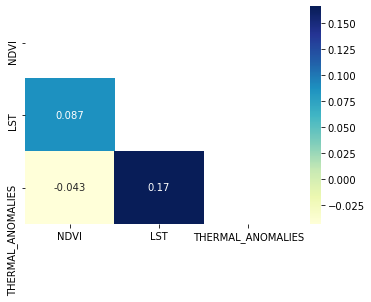

In [ ]:

import seaborn as sns

# Isolate the predictive variables (i.e. remove the response variable)
X = df_WildFires.drop(["CLASS"], axis = 1)

# Determine the correlations between the predictive variables
corr = X.corr()

# The correlation matrix will have values of one along the diagonal
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Construct a heatmap of the correlation matrix
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask, cmap="YlGnBu",
        annot=True)
plt.show()

In [ ]:
# I don't think correlation between variables is a problem because the degree of correlation is very small every paor of vaiables
# (highest being) 0.17

I convert the response categories into numerical values. If there is no fire, I assign the class to be 0. If there is a fire, I assign the class to be 1.

In [ ]:
# Replace qualitative values with integers representing categories.
mapping = {'no_fire': 0, 'fire': 1}
df_WildFires = df_WildFires.replace({'CLASS': mapping})

# Isolate the response variable, y
y = df_WildFires["CLASS"]

Here I standardize the feature variables

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Isolate the feature variable  in X
X = df_WildFires.drop(["CLASS"], axis = 1)

# Standardize the feature variable
X_std = scaler.fit_transform(X)

I divide the dataset into a training set and testing set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, y,
                                                    test_size = 0.2, # 20% of the data is in the test set and 80% of the data is in the training set
                                                    random_state = 0)

I train a logistic regression using the training data set. Then test it using the testing data set and assess the model's performance by printing out both the model accuracy and confusion matrix.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Train a logistic regression model using the training data set
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict whether or not their is a fire in each test observation
y_pred = logreg.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.755
The confusion matrix is:
[[245  11]
 [ 73  14]]


In [ ]:
# Some thoughts
# i - This model has an accuracy of 56% for detecting fires while a trivial null classifier has an average accuracy of 22.5% for
#     detecting fires. Also the model has an accuracy of 77% for detecting no fires while the trivial null classifier has an accuracy
#     of 77.5% for detecting no fires. I conclude that the model, compared to the trivial null classifier, only improves on the fire
#     detection accuracy
# ii - The model has a specificity of 77%
# iii - The model has a sensitivity of 56%
# iv - The model has a precision of 16%

There are more observations without fire than observations with fire. This represents an imbalance in the classes.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Train a logistic regression model using the training data set
logreg_balanced = LogisticRegression(class_weight = 'balanced')
logreg_balanced.fit(X_train, y_train)

# Predict whether or not their is a fire in each test observation
y_pred = logreg_balanced.predict(X_test)

# Print the confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.673
The confusion matrix is:
[[174  82]
 [ 30  57]]


In [ ]:
# Some thoughts

# i -  This model has an accuracy that's 0.73 times that of the previous model for detecting fires; an accuracy that's 1.1
#      times that of the previous model for detecting no fires; and an overall accuracy that's 0.89 times that of the previous model
# ii - The model has a specificity of 85%, 1.1 times that of the previous model
# iii - The model has a sensitivity of 41%, 0.73 times that of the previous model
# iv - The model has a precision of 65.5%, 4 times that of the previous model
# v - Balancing weight becomes important in situations the priority class's data is numerically dwarfed when compared to the other classes
#     prisent in the data. For example, data number of credit card transctions that are fraudulent vs non-fraudulent cases. One would expect
#      the number of fraud cases to be immensely lower than the number of legal transaction in the data. This could skew the performance of any
#      naive model trained on such data

 I plot ROC curves for both the original logistic regression and the logistic regression that balanced the class weights

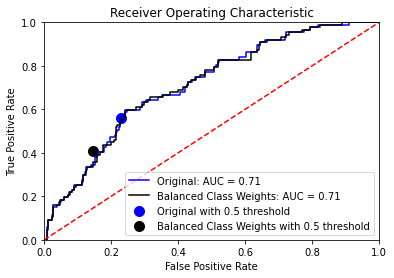

In [ ]:
# Original Logistic Regression Model
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Balanced Logistic Regression Model
probs_balanced = logreg_balanced.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced, tpr_balanced, threshold = metrics.roc_curve(y_test, preds_balanced)
roc_auc_balanced = metrics.auc(fpr_balanced, tpr_balanced)


# From the confusion matrix, plot the operating characteristic for the model


# Original Logistic Regression
fpr_50 = 0.2296 # False positive rate
tpr_50 = 0.56 # True positive rate
# Balanced Logistic Regression Model
fpr_50_balanced = 0.147 # False positive rate
tpr_50_balanced = 0.41 # True positive rate

# Create ROC curve plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Original: AUC = %0.2f' % roc_auc)
plt.scatter(fpr_50, tpr_50, s=100, marker='o', c='b', label = 'Original with 0.5 threshold')
plt.plot(fpr_balanced, tpr_balanced, 'black', label = 'Balanced Class Weights: AUC = %0.2f' % roc_auc_balanced)
plt.scatter(fpr_50_balanced, tpr_50_balanced, s=100, marker='o', c='black', label = 'Balanced Class Weights with 0.5 threshold')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# i - The ROC curves of both original and balacnced class weights are very similar because the class imbalance in the training
#.    dataset was not significant
# ii - The red dotted line represents the No Information Classifier, which occurs when the predictor variables have not connection
#       with the output variable

Here I train a linear discriminant using the training data set; then test it using the testing data setl; and assess the model's performance by printing out both the model's accuracy and confusion matrix.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Train an LDA model using the training data set
lda = LinearDiscriminantAnalysis(store_covariance =  True)
lda.fit(X_train, y_train)

# Predict whether or not there is a fire in each test observation
y_pred = lda.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.758
The confusion matrix is:
[[247   9]
 [ 74  13]]


In [ ]:
# Some thougts
# i - This m and an overall accuracy of 75.8%, that's 1.004 times that of the original model
# ii - The model has a specificity of 85%, 1.1 times that of the original model
# iii - The model has a sensitivity of 76.9%%, 1.0 times that of the original model
# iv - The model has a precision of 14.9%, 0.93 times that of the original model

Visualizing the 3 predictive variables.

In [ ]:
def LDA_2D_plot(x_axis_col, y_axis_col):

    tp = (y_test == y_pred)  # True Positive
    tp0, tp1 = tp[y_test == 0], tp[y_test == 1]
    X0, X1 = X_test[y_test == 0], X_test[y_test == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, x_axis_col], X0_tp[:, y_axis_col], marker='.', color='blue')
    plt.scatter(X0_fp[:, x_axis_col], X0_fp[:, y_axis_col], marker='x',
                s=20, color='#000099')  # dark blue
    # class 1: dots
    plt.scatter(X1_tp[:, x_axis_col], X1_tp[:, y_axis_col], marker='.', color='red')
    plt.scatter(X1_fp[:, x_axis_col], X1_fp[:, y_axis_col], marker='x',
            s=20, color='#990000')  # dark red

    # means
    plt.plot(lda.means_[0][x_axis_col], lda.means_[0][y_axis_col],
        '*', color='yellow', markersize=15, markeredgecolor='blue')
    plt.plot(lda.means_[1][x_axis_col], lda.means_[1][y_axis_col],
        '*', color='yellow', markersize=15, markeredgecolor='red')

    # axis labels
    plt.xlabel(X.columns[x_axis_col])
    plt.ylabel(X.columns[y_axis_col])

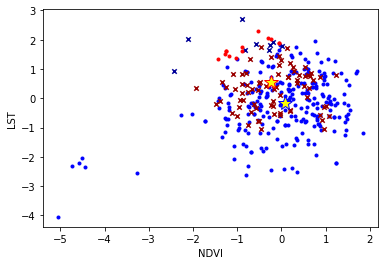

In [ ]:
LDA_2D_plot(0, 1)

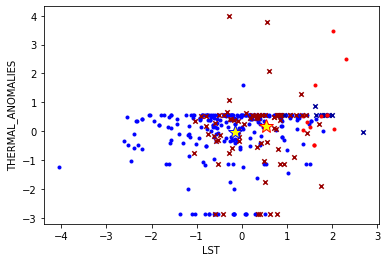

In [ ]:
LDA_2D_plot(1, 2)

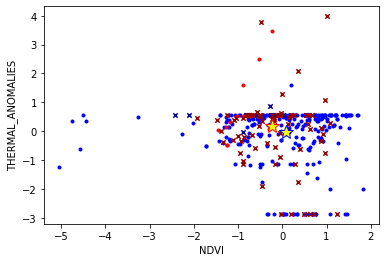

In [ ]:
LDA_2D_plot(0, 2)

I explore using SMOTE to compensating for class imbalance.

In [ ]:
from imblearn.over_sampling import SMOTE

# Balancing the classes using SMOTE
os = SMOTE(random_state = 0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)

# Training a logistic regression model using the training data set
lda_SMOTE = LinearDiscriminantAnalysis(store_covariance =  True)
lda_SMOTE.fit(os_data_X, os_data_y)

# Predict whether or not their is a fire in each test observation
y_pred = lda_SMOTE.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.668
The confusion matrix is:
[[173  83]
 [ 31  56]]


An LDA assumes the same covariance matrix for all classes. The covariance matrix for each of the LDA models can be seen below.

In [ ]:
lda.covariance_

array([[ 0.97744345,  0.10444568, -0.02504435],
       [ 0.10444568,  0.89988647,  0.13903204],
       [-0.02504435,  0.13903204,  0.97133665]])

In [ ]:
lda_SMOTE.covariance_

array([[ 0.84600253,  0.02511204, -0.04541701],
       [ 0.02511204,  0.7603654 ,  0.12703735],
       [-0.04541701,  0.12703735,  0.97466846]])

 Using the training data set, I calculate the covariance matrix for all classes. Then separate the training data set by class (fire and no_fire), and calculate the covariance matrices for each class separately.

In [ ]:
print("covariance with both classes combined:")
np.cov(X_train,rowvar=False)

covariance with both classes combined:


array([[ 0.99492945,  0.06727851, -0.0359617 ],
       [ 0.06727851,  0.98324556,  0.16333571],
       [-0.0359617 ,  0.16333571,  0.97912876]])

In [ ]:
#convert to dataframe for easy manipulation
X_new = pd.DataFrame(X_train, columns = ['X_1','X_2','X_3'])
X_new['y'] = y_train

In [ ]:
#break training data in two groups: fire and nofire
X_fire = X_new[X_new['y'] > 0]
class_1 = X_fire.drop(columns=['y'])
X_no_fire = X_new[X_new['y'] < 1]
class_2 = X_no_fire.drop(['y'],axis=1)

#convariance matrix for fire class features:
print('convariance matrix for fire class features:')
class_1.cov()

convariance matrix for fire class features:


,X_1,X_2,X_3
X_1,1.296086,0.247634,-0.017680
X_2,0.247634,0.927613,0.172616
X_3,-0.017680,0.172616,0.863962


In [ ]:
#convariance matrix for fire class features:
print('convariance matrix for nofire class features:')
class_2.cov()

convariance matrix for nofire class features:


,X_1,X_2,X_3
X_1,0.909632,0.007708,-0.067574
X_2,0.007708,0.995722,0.145645
X_3,-0.067574,0.145645,0.996648


In [ ]:
# Some thoughts.
# The covariance matrices for both classes are very close to one another but not exact,
# so I believe LDA will perform almost as well as the QDA

I train and test a QDA model, print out the accuracy of the model and the confusion matrix.

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Train an QDA model using the training data set
qda = QuadraticDiscriminantAnalysis(store_covariance =  True)
qda.fit(X_train, y_train)

# Predict whether or not there is a fire in each test observation
y_pred = qda.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.758
The confusion matrix is:
[[246  10]
 [ 73  14]]


In [ ]:
qda.covariance_

[array([[ 1.05837473,  0.16231101, -0.01169359],
        [ 0.16231101,  0.97610536,  0.13516762],
        [-0.01169359,  0.13516762,  0.89826144]]),
 array([[ 0.69341128, -0.10262482, -0.07314975],
        [-0.10262482,  0.63225412,  0.15384074],
        [-0.07314975,  0.15384074,  1.24023985]])]

Here is code to balance the class weights using SMOTE when training the model

In [ ]:
from imblearn.over_sampling import SMOTE

# Balance the classes using SMOTE
os = SMOTE(random_state = 0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)

# Train a logistic regression model using the training data set
qda_SMOTE = QuadraticDiscriminantAnalysis(store_covariance =  True)
qda_SMOTE.fit(os_data_X, os_data_y)

# Predict whether or not their is a fire in each test observation
y_pred = qda_SMOTE.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.641
The confusion matrix is:
[[158  98]
 [ 25  62]]


In [ ]:
qda_SMOTE.covariance_

[array([[ 1.05837473,  0.16231101, -0.01169359],
        [ 0.16231101,  0.97610536,  0.13516762],
        [-0.01169359,  0.13516762,  0.89826144]]),
 array([[ 0.63521164, -0.11203999, -0.07922533],
        [-0.11203999,  0.54604667,  0.11914453],
        [-0.07922533,  0.11914453,  1.0528973 ]])]

I plot ROC curves for all three models on the same graph.

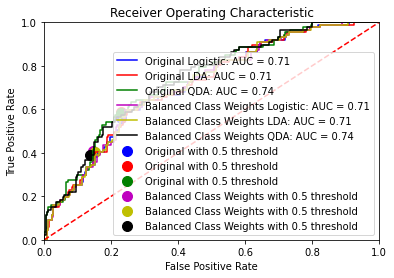

In [ ]:
# Original Logistic Regression Model
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr_logreg, tpr_logreg, threshold = metrics.roc_curve(y_test, preds)
roc_auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)

# Original LDA Model
probs_LDA = lda.predict_proba(X_test)
preds_LDA = probs_LDA[:,1]
fpr_lda, tpr_lda, threshold = metrics.roc_curve(y_test, preds_LDA)
roc_auc_lda = metrics.auc(fpr_lda, tpr_lda)

# Original QDA Model
probs_QDA = qda.predict_proba(X_test)
preds_QDA = probs_QDA[:,1]
fpr_qda, tpr_qda, threshold = metrics.roc_curve(y_test, preds_QDA)
roc_auc_qda = metrics.auc(fpr_qda, tpr_qda)

# Balanced Logistic Regression Model
probs_balanced = logreg_balanced.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced_logreg, tpr_balanced_logreg, threshold = metrics.roc_curve(y_test, preds_balanced)
roc_auc_balanced_logreg = metrics.auc(fpr_balanced_logreg, tpr_balanced_logreg)

# Balanced LDA Model
probs_balanced = lda_SMOTE.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced_lda, tpr_balanced_lda, threshold = metrics.roc_curve(y_test, preds_balanced)
roc_auc_balanced_lda = metrics.auc(fpr_balanced_lda, tpr_balanced_lda)

# Balanced QDA Model
probs_balanced = qda_SMOTE.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced_qda, tpr_balanced_qda, threshold = metrics.roc_curve(y_test, preds_balanced)
roc_auc_balanced_qda = metrics.auc(fpr_balanced_qda, tpr_balanced_qda)


# From the confusion matrix, you can plot the operating characteristic for the model
# Original Logistic Regression
fpr_50_logreg = 0.2296
tpr_50_logreg = 0.56

# Original LDA
fpr_50_lda = 0.23
tpr_50_lda = 0.59

# Original QDA
fpr_50_qda = 0.2288
tpr_50_qda = 0.583

# Balanced Logistic Regression Model
fpr_50_balanced_logreg = 0.147
tpr_50_balanced_logreg = 0.41

# Balanced LDA
fpr_50_balanced_lda = 0.152
tpr_50_balanced_lda = 0.403

# Balanced QDA
fpr_50_balanced_qda = 0.137
tpr_50_balanced_qda = 0.388

# Create ROC curve plot
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_logreg, tpr_logreg, 'b', label = 'Original Logistic: AUC = %0.2f' % roc_auc_logreg)
plt.scatter(fpr_50_logreg, tpr_50_logreg, s=100, marker='o', c='b', label = 'Original with 0.5 threshold')

plt.plot(fpr_lda, tpr_lda, 'r', label = 'Original LDA: AUC = %0.2f' % roc_auc_lda)
plt.scatter(fpr_50_lda, tpr_50_lda, s=100, marker='o', c='r', label = 'Original with 0.5 threshold')

plt.plot(fpr_qda, tpr_qda, 'g', label = 'Original QDA: AUC = %0.2f' % roc_auc_qda)
plt.scatter(fpr_50_qda, tpr_50_qda, s=100, marker='o', c='g', label = 'Original with 0.5 threshold')

plt.plot(fpr_balanced_logreg, tpr_balanced_logreg, 'm', label = 'Balanced Class Weights Logistic: AUC = %0.2f' % roc_auc_balanced_logreg)
plt.scatter(fpr_50_balanced_logreg, tpr_50_balanced_logreg, s=100, marker='o', c='m', label = 'Balanced Class Weights with 0.5 threshold')

plt.plot(fpr_balanced_lda, tpr_balanced_lda, 'y', label = 'Balanced Class Weights LDA: AUC = %0.2f' % roc_auc_balanced_lda)
plt.scatter(fpr_50_balanced_lda, tpr_50_balanced_lda, s=100, marker='o', c='y', label = 'Balanced Class Weights with 0.5 threshold')

plt.plot(fpr_balanced_qda, tpr_balanced_qda, 'black', label = 'Balanced Class Weights QDA: AUC = %0.2f' % roc_auc_balanced_qda)
plt.scatter(fpr_50_balanced_qda, tpr_50_balanced_qda, s=100, marker='o', c='black', label = 'Balanced Class Weights with 0.5 threshold')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#I would recommend the QDA model because it maximizes the area under the ROC curve